# Setup

## Installation

In [1]:
!pip install git+https://github.com/usgs/geomag-algorithms.git
!pip install git+https://github.com/samiriff/mars-ode-data-access.git

  Cloning https://github.com/usgs/geomag-algorithms.git to /tmp/pip-req-build-6m5jl2iw
  Running command git clone -q https://github.com/usgs/geomag-algorithms.git /tmp/pip-req-build-6m5jl2iw
     |████████████████████████████████| 23.9MB 50.7MB/s 
     |████████████████████████████████| 215kB 45.3MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-n9v7o3v2/wheels/dc/8b/cb/0141ac2aa76db65e2037c96bf61b63c26a64a1eb4ddb6f7eeb
  Stored in directory: /root/.cache/pip/wheels/11/d6/40/c448464ae42229b2f9fb46b71be0213e10e9628346b7f1198f
  Stored in directory: /root/.cache/pip/wheels/89/40/f5/7b4f2285aca871b5173887a6c69127210d92806c0d3a977e51
Successfully built geomag-algorithms obspy pycurl
  Cloning https://github.com/samiriff/mars-ode-data-access.git to /tmp/pip-req-build-06zpioul
  Running command git clone -q https://github.com/samiriff/mars-ode-data-access.git /tmp/pip-req-build-06zpioul
     |████████████████████████████████| 19.7MB 1.2MB/s 
     |████████████████████████████████| 20.

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from pathlib import Path
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
!wget -O unet_dataset.zip https://files.slack.com/files-pri/TJRDXSH3L-FL91UDJFR/download/unet_dataset.zip?pub_secret=4ec1f235fb

--2019-07-23 05:56:36--  https://files.slack.com/files-pri/TJRDXSH3L-FL91UDJFR/download/unet_dataset.zip?pub_secret=4ec1f235fb
Resolving files.slack.com (files.slack.com)... 99.84.254.166
Connecting to files.slack.com (files.slack.com)|99.84.254.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134746555 (129M) [application/zip]
Saving to: ‘unet_dataset.zip’

unet_dataset.zip    100%[===================>] 128.50M  38.4MB/s    in 3.4s    

2019-07-23 05:56:40 (38.2 MB/s) - ‘unet_dataset.zip’ saved [134746555/134746555]



In [0]:
!unzip -qq unet_dataset.zip 

## DataBunch Initialization

In [0]:
path = Path('drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train')

In [0]:
path_img = path/'JPEGImages'
path_lbl = path/'SegmentationClassPNG'
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

In [8]:
with open(path/'class_names.txt') as f:
  codes = np.array([line.strip() for line in f.readlines()])
codes

array(['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider'],
      dtype='<U13')

In [0]:
size = 224 # src_size # src_size // 2
bs = 32

In [0]:
import PIL

In [0]:
path_lbl_npy = path/'SegmentationClass'

In [0]:
dir_name = Path('SegmentationLabels')
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
    
def get_segmentation_label_fn(img_f):  
  label_imgname = dir_name/f'{img_f.stem}.png'
  if os.path.exists(label_imgname):
    return label_imgname
  
  npy_filename = path_lbl_npy/f'{img_f.stem}.npy'
  img = PIL.Image.fromarray(np.load(npy_filename))  
  img.save(label_imgname)
  return label_imgname

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_segmentation_label_fn, classes=codes)
      )

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats)
       )

CPU times: user 3.73 s, sys: 1.66 s, total: 5.39 s
Wall time: 8.8 s


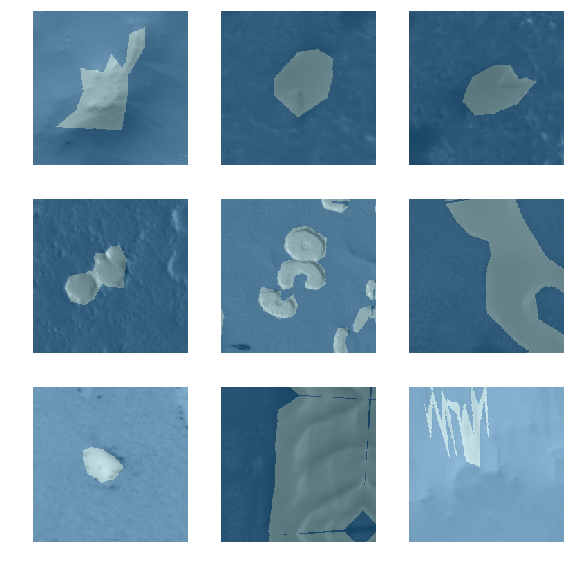

In [15]:
%%time
data.show_batch(rows=3, figsize=(8, 8))

In [16]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['_background_']
void_code

0

## Model Initialization

In [0]:
def acc_camvid(input, target):
  target = target.squeeze(1)
  mask = target != void_code
  return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [18]:
learn = unet_learner(data, models.resnet18, metrics=acc_camvid, wd=1e-2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 20260178.32it/s]


In [19]:
from google.colab import drive
drive.mount('/content/google_drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/google_drive


In [0]:
model_name = 'mars-unet-762394'
!cp 'google_drive/My Drive/Mars-Omdena/{model_name}.pth' 'drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages/models/{model_name}.pth'

In [21]:
learn.load(f'{model_name}')

Learner(data=ImageDataBunch;

Train: LabelList (1387 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Valid: LabelList (287 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: drive/My Drive/Mars-Omdena/Unet_Segmentation_Dataset_Train/JPEGImages;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(

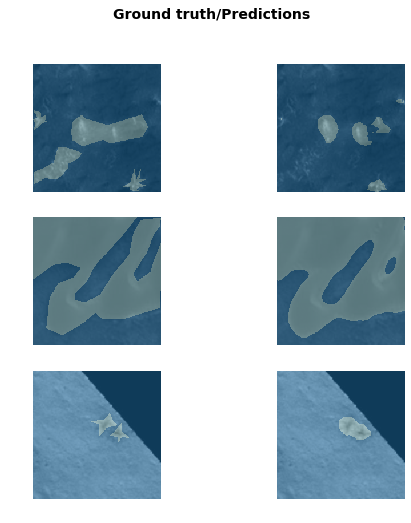

In [22]:
learn.show_results(rows=3, figsize=(8, 8))

In [0]:
!mkdir test

In [24]:
!wget https://hirise-pds.lpl.arizona.edu/PDS/EXTRAS/RDR/AEB/ORB_000000_000099/AEB_000002_0000/AEB_000002_0000_RED.NOMAP.browse.jpg

--2019-07-23 05:58:37--  https://hirise-pds.lpl.arizona.edu/PDS/EXTRAS/RDR/AEB/ORB_000000_000099/AEB_000002_0000/AEB_000002_0000_RED.NOMAP.browse.jpg
Resolving hirise-pds.lpl.arizona.edu (hirise-pds.lpl.arizona.edu)... 128.196.250.179, 2607:f088:0:2::2a
Connecting to hirise-pds.lpl.arizona.edu (hirise-pds.lpl.arizona.edu)|128.196.250.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7473091 (7.1M) [image/jpeg]
Saving to: ‘AEB_000002_0000_RED.NOMAP.browse.jpg’

AEB_000002_0000_RED 100%[===================>]   7.13M  12.6MB/s    in 0.6s    

2019-07-23 05:58:38 (12.6 MB/s) - ‘AEB_000002_0000_RED.NOMAP.browse.jpg’ saved [7473091/7473091]



In [25]:
test_img_name = 'AEB_000002_0000_RED.NOMAP.browse.jpg'
test_img = mpimg.imread(test_img_name)
test_img.shape

(7788, 2048)

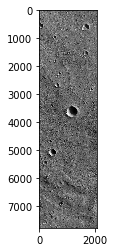

In [26]:
plt.imshow(test_img, cmap='gray')

In [0]:
from fastai.imports import *
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate

classes = ['_background_', 'Crater', 'Dark Dune', 'Slope Streak', 'Bright Dune', 'Impact Ejecta', 'Swiss Cheese', 'Spider']
test_data = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=size).normalize(imagenet_stats)

In [0]:
path = Path('test')

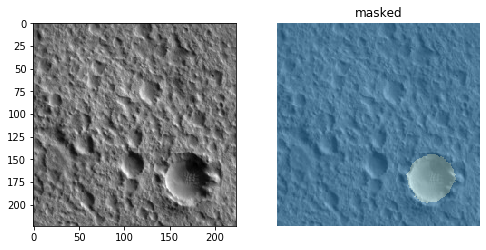

In [58]:
import PIL
test_img_name = 'AEB_000002_0000_RED.NOMAP.browse.jpg'
img = mpimg.imread(test_img_name)
img = PIL.Image.fromarray(img)
row = 0
col = 0
area = (224 * row, 224 * col, 224 * (row + 1), 224 * (col + 1))
cropped_img = img.crop(area)
resized_img = cropped_img.resize((224, 224))
resized_img.save('test/test.jpg')

pred = learn.predict(open_image(path/'test.jpg'))

img = open_image('test/test.jpg')
_, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(resized_img, cmap='gray')
img.show(ax=ax[1], y=pred[0], title='masked')
plt.savefig('huhu.png')

# Prediction Pipeline

## Creating Overlays

In [65]:
img.shape, pred[0].shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

True

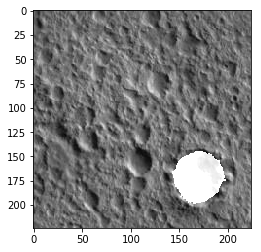

In [216]:
background = cv2.cvtColor(np.rollaxis(img.data.numpy() * 255, 0, 3).astype(np.uint8), cv2.COLOR_RGB2GRAY)
foreground = np.uint8(np.squeeze(pred[0].data.numpy()) * 255)
blended_img = cv2.addWeighted(background, 1, foreground, 0.8, 0)
plt.imshow(blended_img, cmap='gray')
cv2.cv2.imwrite('blended.png', blended_img)

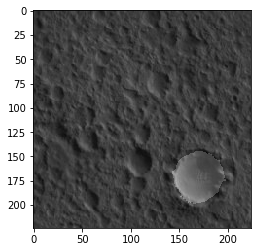

In [210]:
plt.imshow(cv2.imread('blended.png'), cmap='gray')

## Loop

In [264]:
import PIL
test_img_name = 'AEB_000002_0000_RED.NOMAP.browse.jpg'
img = mpimg.imread(test_img_name)
rows, cols = map(lambda x : x // 224, img.shape)
img = PIL.Image.fromarray(img)
print('Rows =', rows, ', Cols =', cols)

Rows = 34 , Cols = 9


In [266]:
img.size

(2048, 7788)

In [0]:
area = (224 * row, 224 * col, 224 * (row + 1), 224 * (col + 1))
cropped_img = img.crop(area)
resized_img = cropped_img.resize((224, 224))
resized_img.save('test/test.jpg')

pred = learn.predict(open_image(path/'test.jpg'))

True

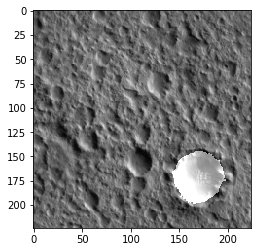

In [232]:
background = np.array(resized_img)
foreground = np.uint8(np.squeeze(pred[0].data.numpy()) * 255)
blended_img = cv2.addWeighted(background, 1, foreground, 0.5, 0)
plt.imshow(blended_img, cmap='gray')
cv2.cv2.imwrite('blended.png', blended_img)

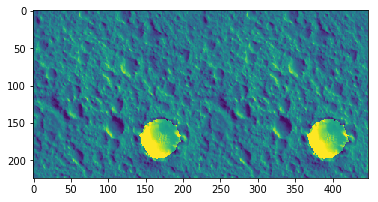

In [236]:
plt.imshow(np.concatenate((blended_img, blended_img), axis=1))

In [270]:
result_img = None
for row in tqdm(range(cols)):
  horizontal_result_img = None
  for col in (range(rows)):
    area = (224 * row, 224 * col, 224 * (row + 1), 224 * (col + 1))
    cropped_img = img.crop(area)
    resized_img = cropped_img.resize((224, 224))
    resized_img.save('test/test.jpg')

    pred = learn.predict(open_image(path/'test.jpg'))

    background = np.array(resized_img)
    foreground = np.uint8(np.squeeze(pred[0].data.numpy()) * 255)
    blended_img = cv2.addWeighted(background, 1, foreground, 0.5, 0)
    
    if horizontal_result_img is None:
      horizontal_result_img = blended_img
    else:
      horizontal_result_img = np.concatenate((horizontal_result_img, blended_img), axis=0)
  if result_img is None:
    result_img = horizontal_result_img
  else:
    result_img = np.concatenate((result_img, horizontal_result_img), axis=1)

In [271]:
result_img.shape

(7616, 2016)

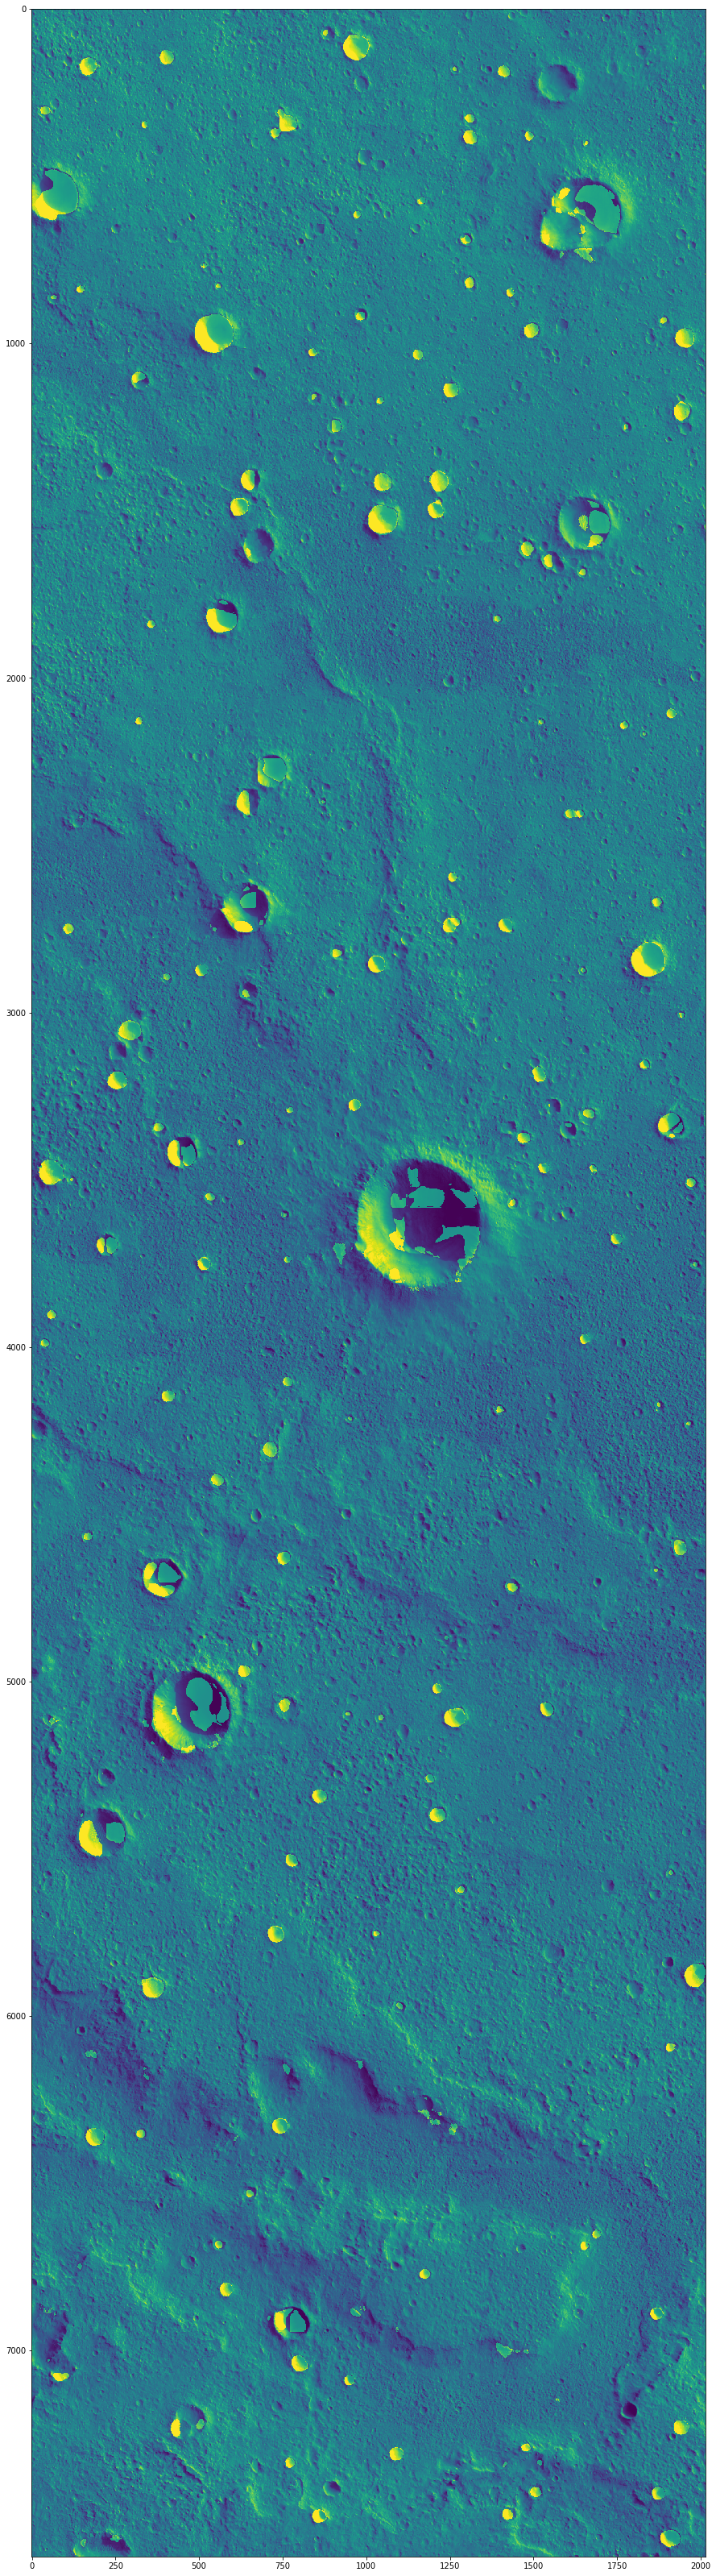

In [274]:
plt.figure(figsize=(15, 100))
plt.imshow(result_img)

In [273]:
cv2.imwrite('result.png', result_img)

True